### 1-) 

* “calculator.tif” dosyasındaki gri ölçekli görüntüde bulunan E harflerini ‘template.tif’ görüntüsünü kullanarak hem isabet-veya-ıska (hit-or-miss) dönüşümü hem de kalıp (template) eşleme yöntemi ile bulmaya çalışınız. 
* İsabet-veya-ıska dönüşümü için işlem öncesinde “calculator.tif” ve template.tif’ görüntülerini bir eşik değeri kullanarak ikili (binary) görüntülere dönüştürünüz. 
* Kalıp eşleme için ise normalleştirilmiş çapraz korelasyon (normalized cross correlation- NCC) formülünün değerini hesaplatarak görüntü üzerinde kalıp ile arama yapınız.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils import img_read
from utils import show_hist
img = img_read('images/calculator.tif', ret_gray=True)
template_img = img_read('images/template.tif', ret_gray=True)

- Template matching
- normalized cross correlation- NCC

[[ 155 1259]
 [ 155 1260]
 [ 605 1030]
 [ 155 1258]
 [ 605 1029]]
[2737.4263 2578.931  2572.539  2563.8906 2546.6096]


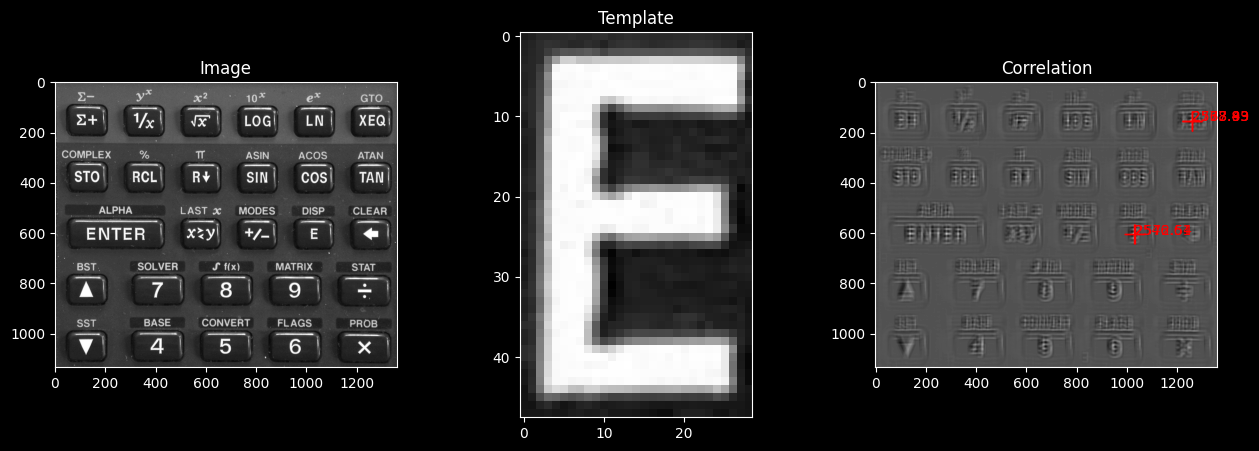

In [9]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    indices = np.dstack(np.unravel_index(indices, ary.shape)).squeeze()
    return indices

# apply template matching using only normalized cross correlation numpy only
# https://docs.opencv.org/3.4/d4/dc6/tutorial_py_template_matching.html
def template_matching(img, template_img, top_n=2):
    template_img = template_img.astype(np.float32)
    img = img.astype(np.float32)

    # normalize
    template_img = (template_img - np.mean(template_img)) / np.std(template_img)
    img = (img - np.mean(img)) / np.std(img)

    # template matching
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html
    from scipy.signal import correlate2d
    corr = correlate2d(img, template_img, mode='same', boundary='symm')
    
    # plot
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Image")
    axes[1].imshow(template_img, cmap='gray')
    axes[1].set_title("Template")
    axes[2].imshow(corr, cmap='gray')
    axes[2].set_title("Correlation")

    # find top mathces
    match_idxs = largest_indices(corr, top_n)
    match_vals = corr[match_idxs[:,0], match_idxs[:,1]]

    print(match_idxs)
    print(match_vals)
    
    # draw the matches
    for idx in match_idxs:
        # write the value of the match
        axes[2].text(idx[1], idx[0], f'{corr[idx[0], idx[1]]:.2f}', color='r')
        # draw a red circle on the image
        axes[2].plot(idx[1], idx[0], 'r+', markersize=15)
    plt.show()

template_matching(img, template_img, top_n=5)

## Hit or Miss

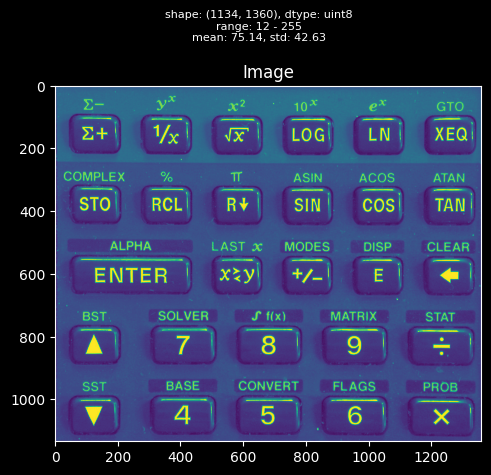

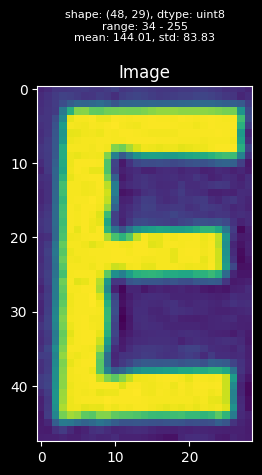

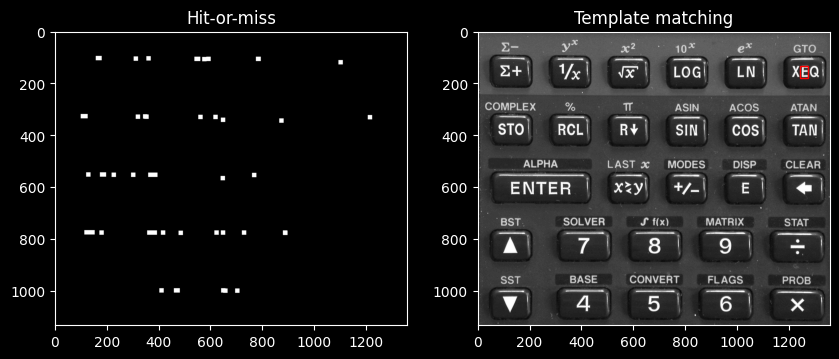

In [16]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils import img_read
from utils import show_hist

image = img_read('calculator.tif', ret_gray=True)
template = img_read('template.tif', ret_gray=True)

# threshold the images
_, image_binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
_, template_binary = cv2.threshold(template, 128, 255, cv2.THRESH_BINARY)

# perform hit-or-miss transformation
kernel = np.array([
                    [0, 1, 0], 
                    [1, -1, 1], 
                    [0, 1, 0]
                    ], np.int8)
result = cv2.morphologyEx(image_binary, cv2.MORPH_HITMISS, kernel)

# perform template matching
res = cv2.matchTemplate(image,template,cv2.TM_CCORR_NORMED)

# find the location of the best match
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# create a rectangle patch
rect_width, rect_height = template.shape[::-1]
rect = Rectangle((max_loc[0], max_loc[1]), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='none')

# display the results using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#result = result*(1/255)
#ax[0].imshow(result, cmap='gray')

kernel = np.ones((3, 3), np.uint8)
result = cv2.dilate(result, kernel, iterations = 8)

ax[0].imshow(result, cmap='gray')
#ax[0].imshow(result, cmap='binary')
ax[0].set_title("Hit-or-miss")

ax[1].imshow(image, cmap='gray')
ax[1].set_title("Template matching")
ax[1].add_patch(rect)
plt.show()